In [14]:
!pip install tensorflow
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
!pip install sklearn
!pip install skimage
!pip install colorama

  Using cached https://files.pythonhosted.org/packages/3b/ee/edbfa69ba7b7d9726e634bfbeefd04b5a1764e9e74867ec916113eeaf4a1/skimage-0.0.tar.gz
ERROR: Command errored out with exit status 1: python setup.py egg_info Check the logs for full command output.


In [16]:
import os
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import cv2
import keras
import math
import numpy as np
import h5py
import colorama
from colorama import Fore, Style
from tensorflow.keras import datasets,models
from numpy import ndarray
from keras.models import Sequential
from keras.layers import Conv2D
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from skimage.metrics import structural_similarity as ssim

In [17]:
#poredimo tj racunamo slicnost izmedju slike A i slike B
# koristeci metriku MSE
# MSE - srednje kvadratna greska izmedju elemenata originalne slike A i
# i izoblicene slike B 
def mean_squared_error(imageA,imageB):
    res = np.power((imageA.astype('float') - imageB.astype('float')),2.)
    res = np.sum(res)
    w = imageA.shape[0]
    h = imageA.shape[1]
    return res/(w*h)
#koristeci psnr
#PSNR - Peak-signal-to-noise-ratio 
# 
# opsta formula za PSNR je: 
# 20*log10((2^n-1)/sqrt(MSE))
# n - broj bitova koristenih za kodiranje elemenata izvorne slike
# kako mi radimo sa 8-bitnim slikama,
# maksimalna amplituda signala je 255 (tj 2^8 -1)
def psnr(imageA,imageB):
    mse = np.power(imageA.astype('float') - imageB.astype('float'),2)
    mse = np.mean(mse)
    if mse == 0:
      return 100
    return 20*math.log10(255.0/math.sqrt(mse))
 
# arg. f-je je  faktor skaliranja slike
def prepare_image(path,factor):
    # prolazimo kroz direktorijum
    # u nasem slucaju taj direktorijum se nalazi na putanji 
    # drive/MyDrive/slike/Set14
    for file in os.listdir(path):
        # povratna vrednost f-je imread je slika koja je ucitana i nalazi se na
        # prosledjenoj putanji path/file 
        img = cv2.imread(path + '/' + file)
        # nakon ucitavanja ispisujemo dimenzije slike
        # ono sto odavde(ako ukljucimo stampanje) mozemo da vidimo je
        # da prvo ide sirina,pa visina,pa broj kanala,
        # nase slike su u boji tako da imamo 3 kanala
        # print('Image: {},dimension: {}'.format(file,img.shape))
    
        #visina,sirina i broj kanala 
        # originalne slike,a zatim i dimenzije modifikovane(sa faktorom umanjenja 
        # factor) slike
        height,width,_ = img.shape
        new_height = int(height/factor)
        new_width = int(width/factor)
        
        # f-ja resize se koristi za promenu velicine slike (sirina,visina)
        # prvo koristimo bilinearnu interpolaciju(ovo je po default-u te nisam morao postaviti parametar interpolation)
        img1 = cv2.resize(img,(new_width,new_height),interpolation = cv2.INTER_LINEAR)  
        img1 = cv2.resize(img1,(width,height),interpolation = cv2.INTER_LINEAR)
        
        # print('Modified image: {},dimension: {}'.format(img,img.shape)) 
        # cuvamo modifikovane slike u direktorijumu slike1(rezultat primene bilinearne interpolacije)
        cv2.imwrite('drive/MyDrive/slike1/{}'.format(file),img1)

        
        # drugo koristimo bikubicnu interpolaciju
        img2 = cv2.resize(img,(new_width,new_height),interpolation = cv2.INTER_CUBIC)  
        img2 = cv2.resize(img2,(width,height),interpolation = cv2.INTER_CUBIC)

        cv2.imwrite('drive/MyDrive/slike2/{}'.format(file),img2)

def odstampaj_rezultate(scores):
  for i in [0,1]:
      if i == 0:
        print('Degradirana slika: \n')
      else:
        print('Rekonstruisana slika: \n')
      print('MSE: ',scores[i][1])
      print('PSNR: ',scores[i][0])
      print('SSIM: ',scores[i][2])
      if i == 0:
        print('--------------------')
def main():
    prepare_image("drive/MyDrive/slike/Set5",2)    

if __name__ == "__main__":
    main()

In [18]:
#konstruisemo model
# metodu Sequential prosledjujemo listu slojeva,zatim kompiliramo nas model
# koriseci optimizator Adam sa faktorom ucenja 0.0003,f-jom gubitka mse,
# koristeci metriku mse za ocenu kvaliteta modela

def model():  
  SRCNN = Sequential([
    Conv2D(filters=128,kernel_size=(9,9),padding='valid',
           activation='relu',kernel_initializer = 'glorot_uniform',
           use_bias=True,input_shape = (None,None,1)),
    Conv2D(filters=64,kernel_size=(3,3),padding='same',
           activation='relu',kernel_initializer = 'glorot_uniform',
           use_bias=True),
    Conv2D(filters=1,kernel_size=(5,5),padding='valid',
           activation='linear',kernel_initializer = 'glorot_uniform',
           use_bias=True)
  ],name = 'MyModel')
  SRCNN.compile(optimizer = Adam(learning_rate=0.0003),loss = 'mean_squared_error',metrics = ['mean_squared_error'])
  return SRCNN

In [19]:
#f-ja koju cropuje(odseca) deo slike
# neophodno je jer prilikom propustanja nasih slika kroz model(SRCNN),
# mi cemo izgubiti neke od "spoljnih" piksela,dakle slike postaju manje i zato nam je neophodno
# da velicina slike bude deljiva sa datim faktorom
def crop_image(img,factor):
  width = img.shape[0]
  height = img.shape[1]
  size = np.array([width,height])
  size = size - np.mod(size,factor)
  img = img[ :size[0], :size[1]]
  return img

# primer za gore definisanu f-ju
# img = cv2.imread('drive/MyDrive/slike1/{}'.format('flowers.bmp'))
# print(img.shape)
# print(crop_image(img,7).shape)

# f-ja crop_borders odseca okvire slike sa svih strana
def crop_borders(image,border):
  img = image[border:-border,border:-border]
  return img


In [20]:
def compare_images(imageA,imageB):
  scores = []
  scores.append(psnr(imageA,imageB))
  scores.append(mean_squared_error(imageA,imageB))
  # ssim  se koristi za poredjenje slicnosti izmedju 2 slike
  # ova mera je napravljena kako bi se unapredile tradicionalne metode za ocenu kvaliteta
  # slike kao sto su gore pomenute psnr i mse 
  # multichannel je ukljucen (True) kako bismo mogli raditi sa slikama koje imaju 3 kanala(BGR ili RGB)
  scores.append(ssim(imageA,imageB,multichannel=True))
  return scores
def configuration_of_model(SRCNN):
  # Prikaz konfiguracije modela
  SRCNN.summary()
  for layer in SRCNN.layers:
    g = layer.get_config()
    h = layer.get_weights()
    print(g)
    print(h)

In [21]:
def predict(SRCNN,image_path):  
  # image_path je putanja do slike
  # split koja se nalazi u podmodulu path modula os
  # deli prosledjenju putanju na 2 dela(head,tail)
  # gde je rep sve posle poslednjeg /
  # a glava je sve do njega zajedno sa njim
  path,file_name = os.path.split(image_path)
  # ucitavamo sliku koristeci metod imread iz modula OpenCV
  # degradirana slika se nalazi na putanji image_path(tj path + '/' + file_name)
  # a referentna slika se nalazi u skupu Set14
  degraded = cv2.imread(path + '/' + file_name)
  ref = cv2.imread('drive/MyDrive/slike/Set5/{}'.format(file_name))  
  #preprocesiranje slike pomocu  f-je crop_image(objasnjenje ove funkcije je navedeno prilikom 
  # definisanja funkcije)
  ref = crop_image(ref,3)
  degraded = crop_image(degraded,3)

  # menjamo prostor boja za sliku degraded
  # iz prostora boja BGR u prostor boja YCrCb
  # ovo radimo zato sto SRCNN mreza radi nad kanalom tj komponentom osvetljenosti Y
  temp = cv2.cvtColor(degraded,cv2.COLOR_BGR2YCrCb)
  # temp.shape[0] - sirina<--
  # temp.shape[1] - visina<-|
  # slike koja je dobijena od slike degraded promenom prostora boja u YCrCb
  Y = np.zeros((1,temp.shape[0],temp.shape[1],1),dtype = 'float')
  # vrsimo normalizaciju vrednosti,tj svodimo na interval od 0 do 1(deljenjem sa 255)
  # zbog obucavanja nase SRCNN mreze
  Y[0,:,:,0] = temp[:,:,0].astype(float)/255
  pre = SRCNN.predict(Y,batch_size=1)
  # postprocesiranje 
  pre *= 255 #mnozenje svakog piksela sa 255(posto u ovom momentu imamo normalizovane vr piksela)
  pre[pre[:]>255]=255 #bilo koji piksel koji je izvan opsega(>255) postavljamo na 255
  pre[pre[:]<0]=0#bilo koji piksel koji je izvan opsega(<0) postavljamo na 0
  pre = pre.astype(np.uint8)
  

  temp = crop_borders(temp,6)
  temp[ : , : ,0]=pre[0, : , : ,0]
  # konvertovanje u BGR prostor boja
  output = cv2.cvtColor(temp,cv2.COLOR_YCrCb2BGR)
  # uklanjamo ivice slika (ref,degraded) kako bi sve slike(ref,degraded koje su niskog kvaliteta) i izlazna slika(output)
  # bile iste velicine
  ref = crop_borders(ref.astype(np.uint8),6)
  degraded = crop_borders(degraded.astype(np.uint8),6)
  # racunamo kvalitet slike
  scores = []
  scores.append(compare_images(degraded,ref))
  scores.append(compare_images(output,ref))
  # vracamo slike(ref,degraded,output) i rezulate (scores)
  return ref,degraded,output,scores


In [22]:
SRCNN = model()
SRCNN.load_weights('drive/MyDrive/3051crop_weight_200.h5',by_name = False)  
configuration_of_model(SRCNN)

Model: "MyModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, None, None, 128)   10496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 64)    73792     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 1)     1601      
Total params: 85,889
Trainable params: 85,889
Non-trainable params: 0
_________________________________________________________________
{'name': 'conv2d_3', 'trainable': True, 'batch_input_shape': (None, None, None, 1), 'dtype': 'float32', 'filters': 128, 'kernel_size': (9, 9), 'strides': (1, 1), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initia

Rezultati za sliku woman_GT.bmp
Degradirana slika: 

MSE:  225.3165263748597
PSNR:  29.374085683369664
SSIM:  0.9336749260789752
--------------------
Rekonstruisana slika: 

MSE:  84.53644781144781
PSNR:  33.631576205958524
SSIM:  0.9653791777540882


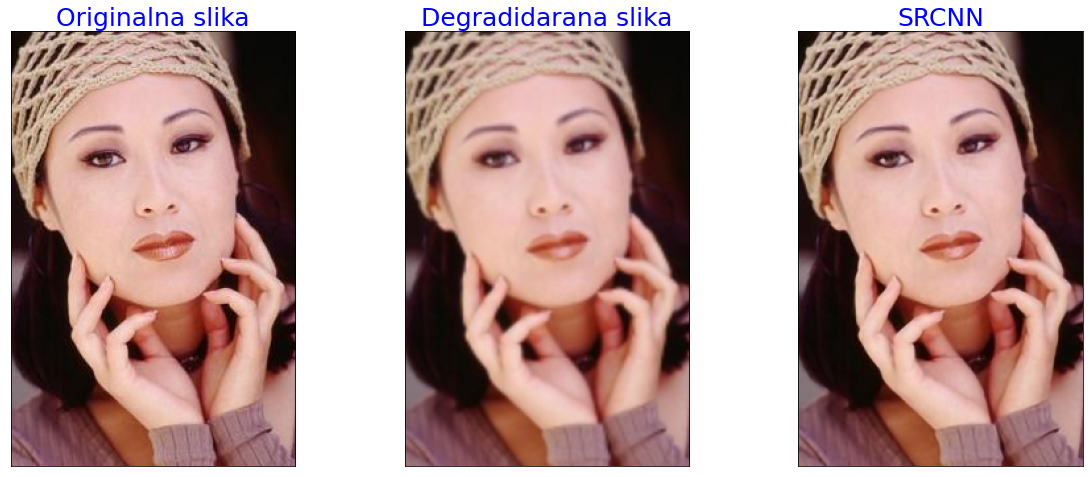

In [23]:
ref,degraded,output,scores = predict(SRCNN,'drive/MyDrive/slike1/woman_GT.bmp')
print('Rezultati za sliku woman_GT.bmp')
odstampaj_rezultate(scores)

fig = plt.figure(num=1,figsize=(20,8),edgecolor='red',frameon=True)
images = [ref,degraded,output]
naslov_slike = ['Originalna slika','Degradidarana slika','SRCNN']
for i in range(3):
  ax = fig.add_subplot(1,3,i+1)
  imgplot = plt.imshow(cv2.cvtColor(images[i],cv2.COLOR_BGR2RGB))  
  ax.set_title(naslov_slike[i],fontdict={'fontsize': 25, 'fontweight': 'medium','color':'blue'})
  ax.set_xticks([])
  ax.set_yticks([])

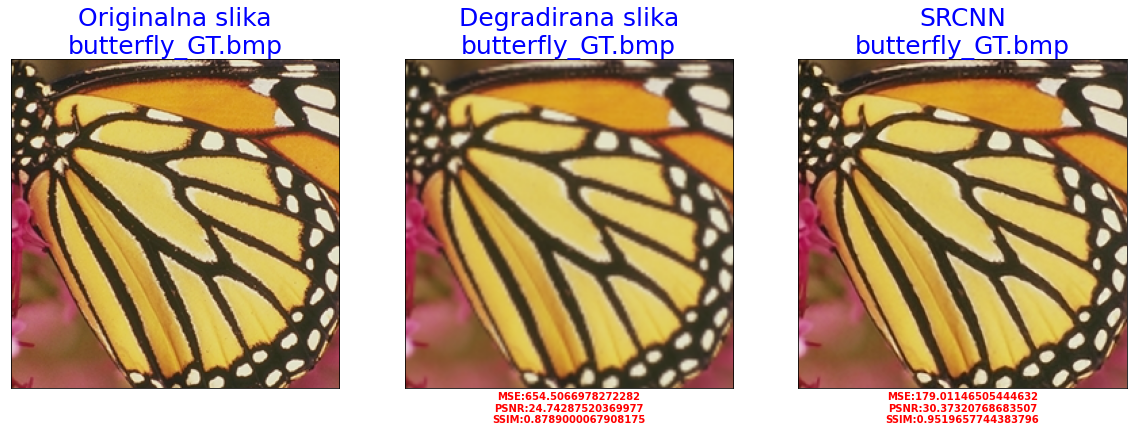

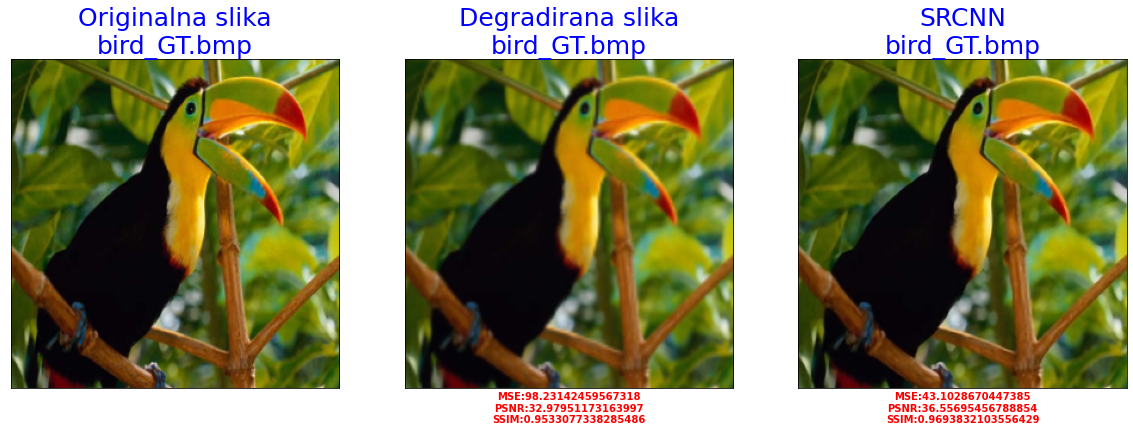

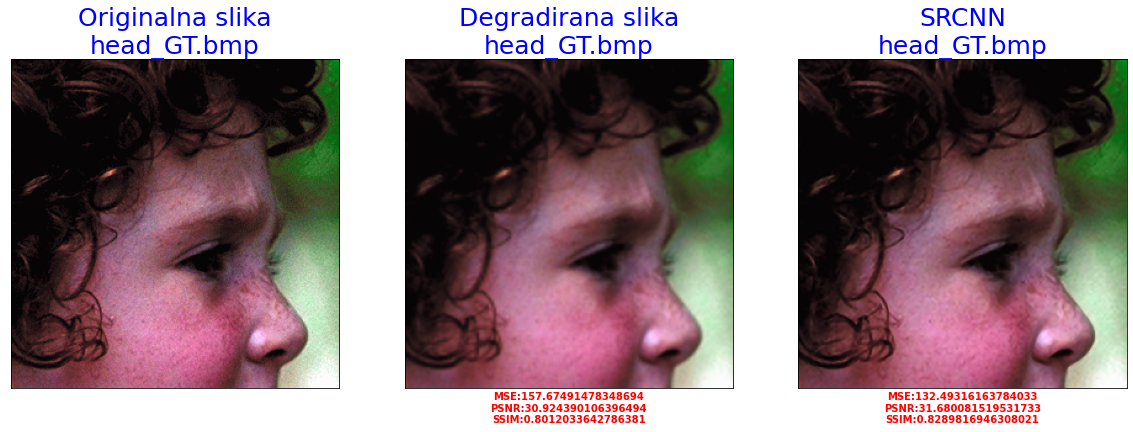

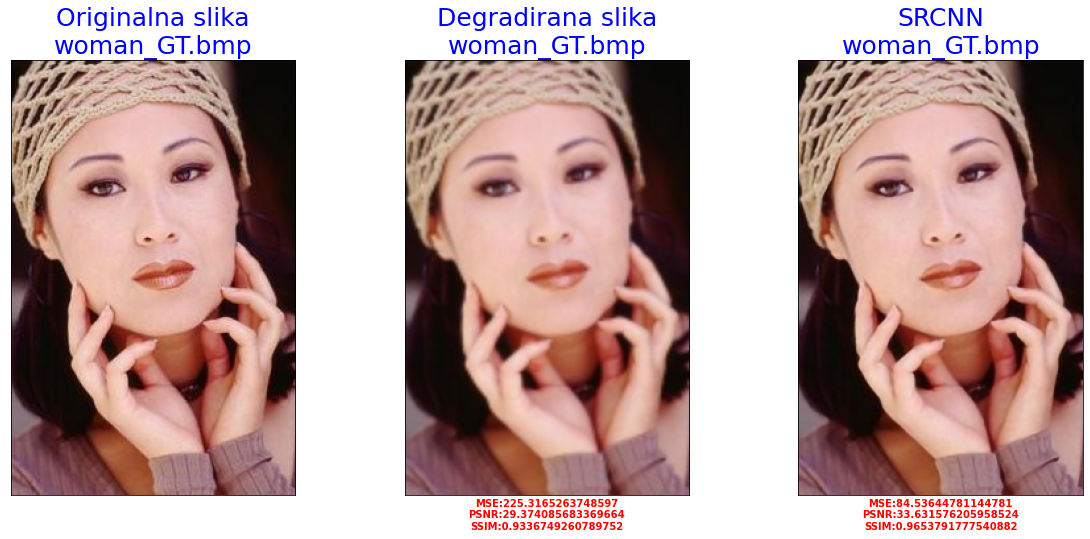

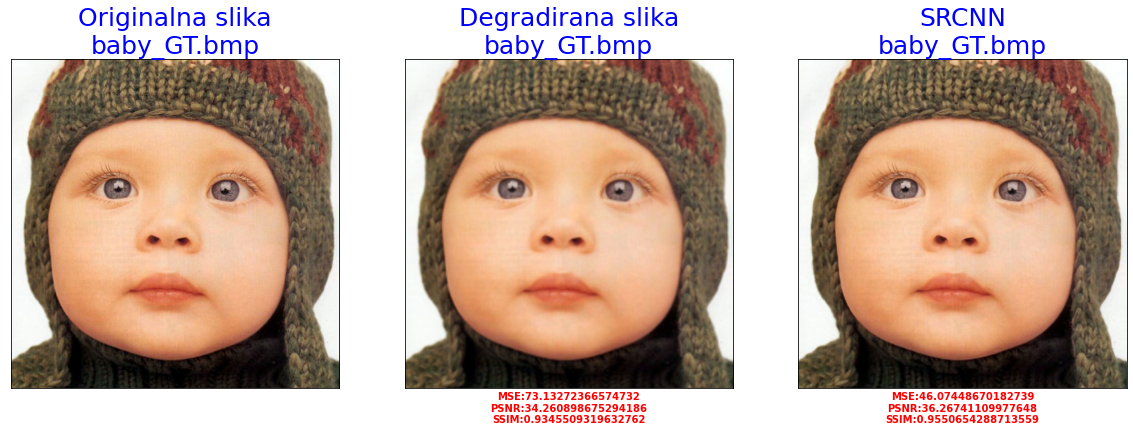

In [24]:
path_to_dir = 'drive/MyDrive/slike1/'
types = ['Originalna slika','Degradirana slika','SRCNN']
for image in os.listdir(path_to_dir):
  ref,degraded,output,scores = predict(SRCNN,'drive/MyDrive/slike1/{}'.format(image))
  images = [ref,degraded,output]
  _,axs = plt.subplots(nrows=1,ncols=3,figsize = (20,8))
  
  
  axs[0].imshow(cv2.cvtColor(images[0],cv2.COLOR_BGR2RGB))
  axs[0].set_title(types[0] + '\n{}'.format(image),fontdict={'fontsize': 25, 'fontweight': 'medium','color':'blue'})
  axs[0].set_xticks([])
  axs[0].set_yticks([])

  for j in range(1,3):
    axs[j].imshow(cv2.cvtColor(images[j],cv2.COLOR_BGR2RGB))
    axs[j].set_xlabel('MSE:{}\nPSNR:{}\nSSIM:{}'.format(scores[j-1][1],scores[j-1][0],scores[j-1][2]),fontdict={'fontweight':'bold','color':'r'})
    # axs[j].set(xlabel = 'MSE:{}\nPSNR:{}\nSSIM:{}'.format(scores[j-1][1],scores[j-1][0],scores[j-1][2]))
    axs[j].set_title(types[j] + '\n{}'.format(image),fontdict={'fontsize': 25, 'fontweight': 'medium','color':'blue'})
    axs[j].set_xticks([])
    axs[j].set_yticks([])
  

Poredjenje originalne slike i interpolirane(bikubicna interpolacija)


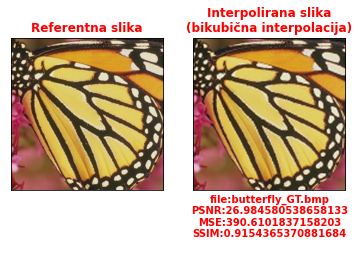

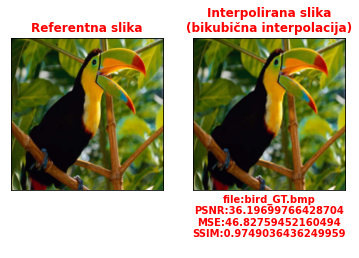

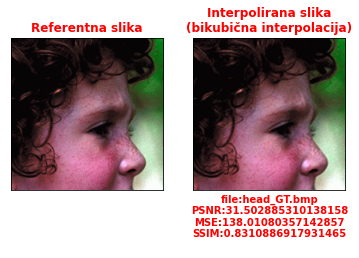

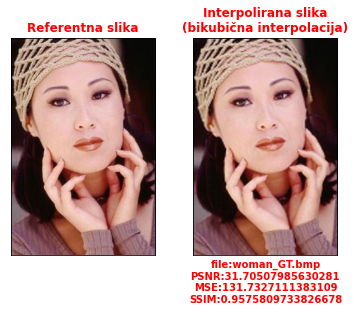

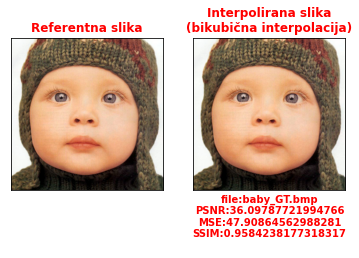

In [25]:
print(Fore.BLUE + 'Poredjenje originalne slike i interpolirane(bikubicna interpolacija)')
for file in os.listdir('drive/MyDrive/slike2/'):
  imageA = cv2.imread('drive/MyDrive/slike2/{}'.format(file))
  imageB = cv2.imread('drive/MyDrive/slike/Set5/{}'.format(file))
  
  Psnr = psnr(imageA,imageB)
  Mse = mean_squared_error(imageA,imageB)
  SSIM = ssim(imageA,imageB,multichannel=True)

  fig = plt.figure()
  ax = fig.add_subplot(1, 2, 1)
  imgplot = plt.imshow(cv2.cvtColor(imageB,cv2.COLOR_BGR2RGB))
  ax.set_title('Referentna slika',fontdict={'fontweight': 'bold','color':'red'})
  ax.set_xticks([])
  ax.set_yticks([])
  
  ax = fig.add_subplot(1, 2, 2)
  imgplot = plt.imshow(cv2.cvtColor(imageA,cv2.COLOR_BGR2RGB))
  # imgplot.set_clim(0.0, 0.7)
  ax.set_title('Interpolirana slika\n(bikubična interpolacija)',fontdict={'fontweight': 'bold','color':'red'})
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_xlabel('file:{}\nPSNR:{}\nMSE:{}\nSSIM:{}\n'.format(file,Psnr,Mse,SSIM),fontdict={'fontweight': 'bold','color':'red'})
  

Poredjenje originalne slike i interpolirane(bilinearna)


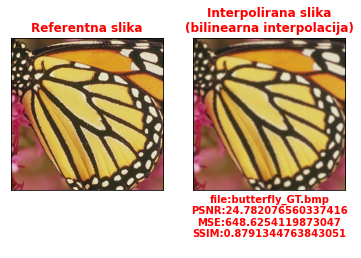

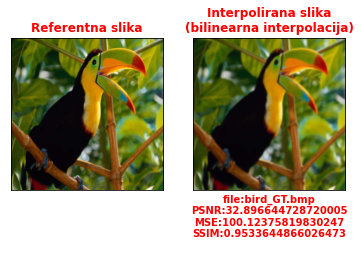

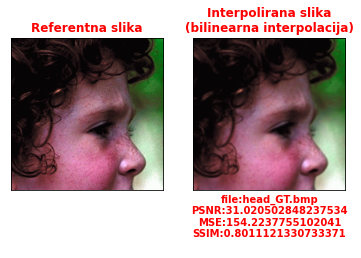

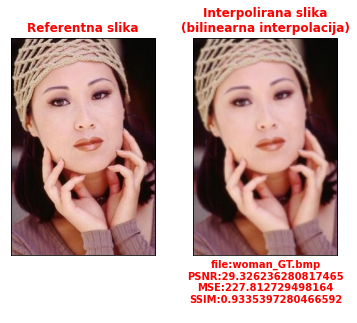

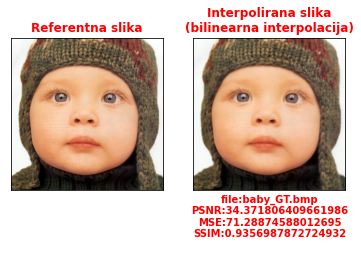

In [26]:
print(Fore.BLUE + 'Poredjenje originalne slike i interpolirane(bilinearna)')
for file in os.listdir('drive/MyDrive/slike1/'):
  imageA = cv2.imread('drive/MyDrive/slike1/{}'.format(file))
  imageB = cv2.imread('drive/MyDrive/slike/Set5/{}'.format(file))
  
  Psnr = psnr(imageA,imageB)
  Mse = mean_squared_error(imageA,imageB)
  SSIM = ssim(imageA,imageB,multichannel=True)

  fig = plt.figure()
  ax = fig.add_subplot(1, 2, 1)
  imgplot = plt.imshow(cv2.cvtColor(imageB,cv2.COLOR_BGR2RGB))
  ax.set_title('Referentna slika',fontdict={'fontweight': 'bold','color':'red'})
  ax.set_xticks([])
  ax.set_yticks([])
  
  ax = fig.add_subplot(1, 2, 2)
  imgplot = plt.imshow(cv2.cvtColor(imageA,cv2.COLOR_BGR2RGB))
  imgplot.set_clim(0.0, 0.7)
  ax.set_title('Interpolirana slika\n(bilinearna interpolacija)',fontdict={'fontweight': 'bold','color':'red'})
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_xlabel('file:{}\nPSNR:{}\nMSE:{}\nSSIM:{}\n'.format(file,Psnr,Mse,SSIM),fontdict={'fontweight': 'bold','color':'red'})
